In [1]:
import os
import sys

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf


import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [2]:
# Dataset
object_labels = [10]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



0it [00:00, ?it/s]

5683it [00:03, 1642.94it/s]


Lenght of the dataset! 17049


In [41]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

len_objects = len(object_labels)
toPILimage = ToPILImage()
iid = 9999

In [42]:
print(f'Length of the dataset: {len(test_dataset)}')

# NEW SLICE
print(test_dataset.images[0], '\n',test_dataset.images[1], '\n',test_dataset.images[2])

Length of the dataset: 17049
[PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-000329.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-000329.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera05_colorimage-000329.jpg')]


In [43]:
# Get the first three images
cam1 = test_dataset.images[iid]
cam4 = test_dataset.images[iid + 1]
cam5 = test_dataset.images[iid + 2]

print(f'Cam1: {cam1}, Cam4: {cam4}, Cam5: {cam5}')

# Use get item: 0) VideoDataBatch 1) Segmentation mask
cam1_vid = test_dataset[iid][0]
cam4_vid = test_dataset[iid + 1][0]
cam5_vid = test_dataset[iid + 2][0]

# Use first frame
cam1 = cam1_vid.frames[0].data
cam4 = cam4_vid.frames[0].data
cam5 = cam5_vid.frames[0].data

gt_mask1 = cam1_vid.frames[0].objects[0].segment
gt_mask4 = cam4_vid.frames[0].objects[0].segment
gt_mask5 = cam5_vid.frames[0].objects[0].segment

print(gt_mask1.shape)
print(gt_mask1.dtype)

Cam1: [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-003662.jpg')], Cam4: [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-003662.jpg')], Cam5: [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera05_colorimage-003662.jpg')]
torch.Size([512, 512])
torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


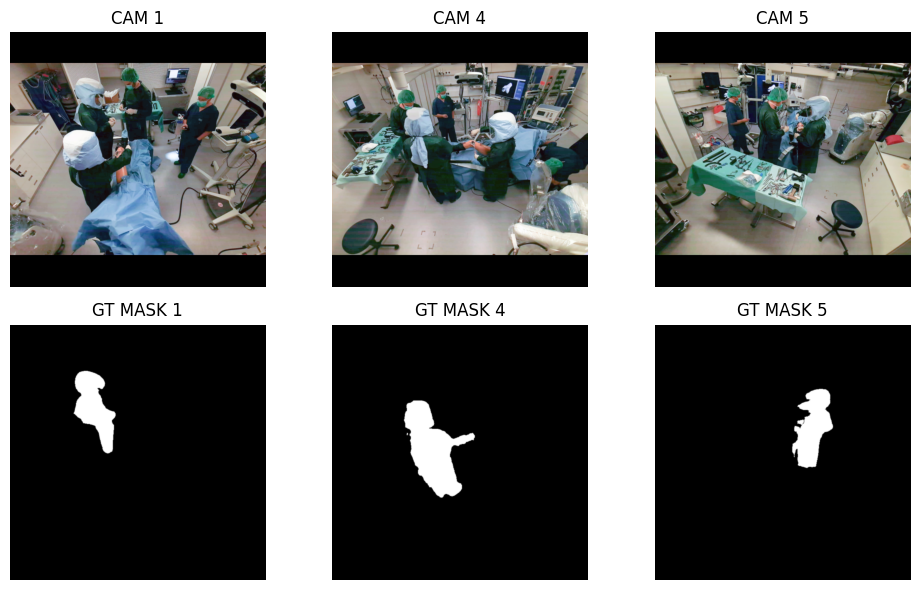

In [44]:
# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Transpose from tensor to numpy shape
cam1 = revert_transform(cam1).permute(1,2,0)
cam4 = revert_transform(cam4).permute(1,2,0)
cam5 = revert_transform(cam5).permute(1,2,0)

# First row (RGB, GT, Black Placeholder)
axes[0,0].imshow(cam1)
axes[0,0].set_title("CAM 1")

axes[0,1].imshow(cam4)
axes[0,1].set_title("CAM 4")

axes[0,2].imshow(cam5)
axes[0,2].set_title("CAM 5")

axes[1,0].imshow(gt_mask1, cmap='gray')
axes[1,0].set_title("GT MASK 1")

axes[1,1].imshow(gt_mask4, cmap='gray')
axes[1,1].set_title("GT MASK 4")

axes[1,2].imshow(gt_mask5, cmap='gray')
axes[1,2].set_title("GT MASK 5")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [45]:
is_black_row = (cam1[:,:,0] <= 0)  # Check along width and channels
pos_padding = np.where(is_black_row == False)
start = pos_padding[0][0]
end = pos_padding[0][-1]

# Slice the predictions and ground truth masks
if start == 64:
    cam1 = cam1[start:end+1, :, :]
    cam4 = cam4[start:end+1, :, :]
    cam5 = cam5[start:end+1, :, :]
elif start == 0:
    pass
else:
    raise ValueError("Padding not found in the image")

In [46]:
import os
import json

import cv2
import numpy as np
from scipy.spatial.transform import Rotation

def skew(t):
    return np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])

In [47]:
def compute_epipolar_lines(F, pts1):
    # pts1: Nx2 array
    pts1_h = np.hstack((pts1, np.ones((pts1.shape[0], 1))))  # homogeneous
    lines2 = (F @ pts1_h.T).T  # Each row is [a, b, c]
    return lines2

def draw_epilines(img2, lines, colors, padding=0):
    h, w = img2.shape[:2]
    for r, color in zip(lines, colors):
        color = color.tolist() if isinstance(color, np.ndarray) else color
        # a, b, c = r
        # x0, x1 = 0, w
        # y0 = int((-c - a * x0) / b)
        # y1 = int((-c - a * x1) / b)
        x0,y0 = map(int, [0, -(r[2])/r[1] - padding])
        x1,y1 = map(int, [w, -(r[2] + r[0]*w)/r[1] - padding])
        img2 = cv2.line(img2, (x0, y0), (x1, y1), color, 2)
    return img2

In [48]:
def load_camera_data(camera_data, downscale=1):
    h, w = camera_data['value0']['color_parameters']['height'], camera_data['value0']['color_parameters']['width']
    h_, w_ = h // downscale, w // downscale
    # padding = (w_ - h_) // 2
    padding = 0
    intrinsics_json = camera_data['value0']['color_parameters']['intrinsics_matrix']
    K = np.asarray([[intrinsics_json['m00'] / downscale, intrinsics_json['m10'], intrinsics_json['m20'] / downscale],
                    [intrinsics_json['m01'], intrinsics_json['m11'] / downscale, intrinsics_json['m21'] / downscale + padding],
                    [0, 0, 1]])
    # Extrinsics Depth
    extrinsics_json = camera_data['value0']['camera_pose']
    trans = extrinsics_json['translation']
    rot = extrinsics_json['rotation']
    extrinsics = np.zeros((4, 4), dtype=np.float32)
    R = Rotation.from_quat([rot['x'], rot['y'], rot['z'], rot['w']]).as_matrix()
    extrinsics[:3, :3] = R
    t = [trans['m00'], trans['m10'], trans['m20'], 1]
    extrinsics[:, 3] = t

    # Extrinsics Color
    color2depth_json = camera_data['value0']['color2depth_transform']
    trans = color2depth_json['translation']
    rot = color2depth_json['rotation']
    color2depth_transform = np.zeros((4, 4), dtype=np.float32)
    rot_matrix = Rotation.from_quat([rot['x'], rot['y'], rot['z'], rot['w']]).as_matrix()
    color2depth_transform[:3, :3] = rot_matrix
    color2depth_transform[:, 3] = [trans['m00'], trans['m10'], trans['m20'], 1]
    depth_extrinsics = np.copy(extrinsics)
    extrinsics = extrinsics @ color2depth_transform  # Extrinsics were given for the depth camera, convert them to color camera
    extrinsics = extrinsics @ np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]], dtype=np.float32)

    # Distortion
    rad_dist = camera_data['value0']['color_parameters']['radial_distortion']
    tan_dist = camera_data['value0']['color_parameters']['tangential_distortion']
    dist = [rad_dist.pop('m00'), rad_dist.pop('m10'), tan_dist.pop('m00'), tan_dist.pop('m10')]
    dist += [rd for rd in rad_dist.values()]
    dist = np.array(dist, dtype=np.float32)

    return K, extrinsics, padding, dist, depth_extrinsics

In [49]:
downscale = 4
take_path = '/home/polyaxon-data/data1/MM-OR_processed/001_PKA/'
camera_files = ['camera01.json', 'camera04.json', 'camera05.json']
camera_int_ext = []
for json_file in camera_files:
    with open(os.path.join(take_path, json_file), 'r') as f:
        camera_data = json.load(f)
    intr, ext, padding, dist, depth_ext = load_camera_data(camera_data, downscale)
    camera_int_ext.append((intr, ext, dist, depth_ext))

In [50]:
K0, ext0, dist0, depth_ext0 = camera_int_ext[0]
K1, ext1, dist1, depth_ext1 = camera_int_ext[1]
K2, ext2, dist2, depth_ext2 = camera_int_ext[2]

# Sanity Check (works fine)
# R = R1 @ R0.T
# t = t1 - R @ t0

In [51]:
# Assuming the transforms are from camera coordinates to world
inv0 = np.zeros((4, 4), dtype=np.float32)
inv0[:3, :3] = ext0[:3,:3].T
inv0[:3, 3] = -ext0[:3,:3].T @ ext0[:3, 3]
ext_1_to_0 = inv0 @ ext1
ext_2_to_0 = inv0 @ ext2

In [60]:
# Define points in image 4
y, x = torch.where(gt_mask4 == 255)
y -= start  # We remove the padding should lift the mask
pts_cam4 = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1).numpy()[0:1]

# Define Points in Image 5
y, x = torch.where(gt_mask5 == 255)
y -= start  # We remove the padding should lift the mask
pts_cam5 = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1).numpy()[0:1]

Project Cam 4 Points on Cam 1

In [61]:
# Define colors for points
num_points = pts_cam4.shape[0]
colors = plt.cm.jet(np.linspace(0, 1, num_points))[:, :3] * 255  # RGB 0-255
colors = colors.astype(np.uint8)
flag_fundamental = True
cam1_draw = cam1.numpy().copy()

# Compute Epipolar Lines
R, t = ext_1_to_0[:3, :3], ext_1_to_0[:3, 3]
E = skew(t) @ R
inv_K1 = np.linalg.inv(K1)
inv_K0 = np.linalg.inv(K0)
F = inv_K0.T @ E @ inv_K1
lines2 = compute_epipolar_lines(F, pts_cam4)

# Draw Epipolar Lines
cam1_draw = draw_epilines(cam1_draw, lines2, colors, padding=padding)

# We know that the epipole 1 is scaled to R.T @ t and we know that the epipole 2 is scaled to t
epipole = t
epipole =  epipole / epipole[-1]
epipole_px = K0 @ epipole

# Draw Epipole
ep_ctr = (np.round(epipole_px[0].astype(int)), np.round(epipole_px[1].astype(int)) - padding)
cam1_draw = cv2.circle(cam1_draw, ep_ctr, 4, [0, 255, 0], -1)

Project Cam 5 Points on Cam 1

In [62]:
# Define colors for points
num_points = pts_cam5.shape[0]
colors = plt.cm.jet(np.linspace(0, 1, num_points))[:, :3] * 255  # RGB 0-255
colors = colors.astype(np.uint8)

# Compute Epipolar Lines
R, t = ext_2_to_0[:3, :3], ext_2_to_0[:3, 3]
E = skew(t) @ R
inv_K0 = np.linalg.inv(K0)
inv_K2 = np.linalg.inv(K2)
F = inv_K0.T @ E @ inv_K2
lines2 = compute_epipolar_lines(F, pts_cam5)

# Draw Epipolar Lines
cam1_draw = draw_epilines(cam1_draw, lines2, colors, padding=padding)

# Draw Epipole
epipole = t
epipole =  epipole / epipole[-1]
epipole_px = K0 @ epipole

# Draw Epipole
ep_ctr = (np.round(epipole_px[0].astype(int)), np.round(epipole_px[1].astype(int)) - padding)
cam1_draw = cv2.circle(cam1_draw, ep_ctr, 4, [0, 255, 0], -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005418954..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..127.0].


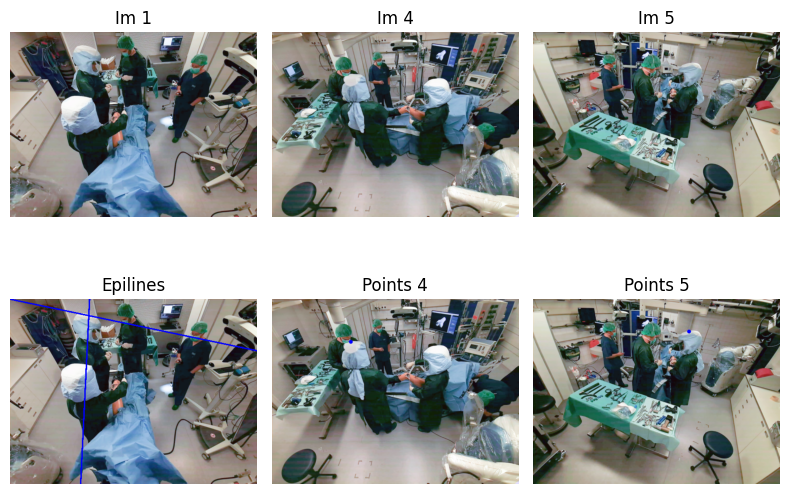

In [65]:
img4_color = cam4.numpy().copy()
for pt, color in zip(pts_cam4, colors):
    pt_int = tuple(np.round(pt).astype(int))
    img4_color = cv2.circle(img4_color, pt_int, 4, color.tolist(), -1)

img5_color = cam5.numpy().copy()
for pt, color in zip(pts_cam5, colors):
    pt_int = tuple(np.round(pt).astype(int))
    img5_color = cv2.circle(img5_color, pt_int, 4, color.tolist(), -1)
    
figsize = np.array([8,6])
fig, axs = plt.subplots(2, 3, figsize=figsize, )

axs[0,0].imshow(cam1.numpy().copy())
axs[0,0].axis('off')
axs[0,0].set_title("Im 1")

axs[0,1].imshow(cam4.numpy().copy())
axs[0,1].axis('off')
axs[0,1].set_title("Im 4")

axs[0,2].imshow(cam5.numpy().copy())
axs[0,2].axis('off')
axs[0,2].set_title("Im 5")

axs[1,0].imshow(cam1_draw)
axs[1,0].axis('off')
axs[1,0].set_title("Epilines")

axs[1,1].imshow(img4_color)
axs[1,1].axis('off')
axs[1,1].set_title("Points 4")

axs[1,2].imshow(img5_color)
axs[1,2].axis('off')
axs[1,2].set_title("Points 5")

plt.tight_layout()
plt.show()